## Evaluation trial for SENA norman dataset

In [1]:
import os
import sys
import argparse
import json
import pickle
from typing import List, Tuple

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

path = os.path.abspath('../SENA/src/sena_discrepancy_vae/')
print(path)
sys.path.insert(0, path)

from utils import MMD_loss, LossFunction

/wdir/tfm/SENA/src/sena_discrepancy_vae


In [2]:
savedir = '../cris_test/models/sena_norman_1'
mode = 'double'
numint = 2
device = 'cuda:0'

data_file_map = {
    "train": "train_data.pkl",
    "test": "test_data_single_node.pkl",
    "double": "double_data.pkl",
}

config_path = os.path.join(savedir, "config.json")
model_path = os.path.join(savedir, "best_model.pt")
data_path = os.path.join(savedir, data_file_map[mode])

In [3]:
data_path

'../cris_test/models/sena_norman_1/double_data.pkl'

In [4]:
if os.path.exists(data_path):
    with open(data_path, "rb") as f:
        dataloader = pickle.load(f)
else:
    raise FileNotFoundError(f"{mode} data file not found at {data_path}")

In [5]:
if os.path.exists(model_path):
    model = torch.load(model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

In [6]:
ptb_path = os.path.join(savedir, "ptb_targets.pkl")
if os.path.exists(ptb_path):
    with open(ptb_path, "rb") as f:
        ptb_genes = pickle.load(f)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

In [7]:
# Load config from the savedir
if os.path.exists(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
else:
    # If config file does not exist, use default values or raise an error
    config = {}
    print(f"Warning: Config file not found in {savedir}. Using default parameters.")

MMD_sigma = config.get("MMD_sigma", 200.0)
kernel_num = config.get("kernel_num", 10)
matched_IO = config.get("matched_IO", False)
temp = config.get("temp", 1000.0)
seed = config.get("seed", 42)
latdim = config.get("latdim", 105)
model_name = config.get("name", "example")
batch_size = 10

In [ ]:
pred_x_list, gt_x_list = [], []
gt_y_list, pred_y_list = [], []
c_y_list, mu_list, var_list = [], [], []
MSE_l, KLD_l, L1_l, MMD_l = [], [], [], []
cidx_list = []

mmd_loss_func = MMD_loss(fix_sigma=MMD_sigma, kernel_num=kernel_num)
loss_f = LossFunction(MMD_sigma=MMD_sigma, kernel_num=kernel_num, matched_IO=matched_IO)

for i, X in enumerate(tqdm(dataloader, desc="evaluating loader")):
    x, y, c = X[0].to(device), X[1], X[2].to(device)
    
    if numint == 2:
        idx = torch.nonzero(torch.sum(c, axis=0), as_tuple=True)[0]
        c1 = torch.zeros_like(c).to(device)
        c1[:, idx[0]] = 1
        c2 = torch.zeros_like(c).to(device)
        c2[:, idx[1]] = 1
        idx_pair = idx.cpu()
        cidx_list.append(idx_pair.numpy())
    else:
        c1 = c2 = c
    
    with torch.no_grad():
        y_hat, x_recon, z_mu, z_var, G, _ = model(
            x, c1, c2, num_interv=numint, temp=temp
            )
        
    gt_x_list.append(x.cpu())
    pred_x_list.append(x_recon.cpu())

    gt_y_list.append(y)
    pred_y_list.append(y_hat.cpu())

    c_y_list.append(c.cpu())
    mu_list.append(z_mu.cpu())
    var_list.append(z_var.cpu())

    if not i % batch_size:
        # Stack tensors
        gt_x = torch.vstack(gt_x_list)
        pred_x = torch.vstack(pred_x_list)
        gt_y = torch.vstack(gt_y_list)
        pred_y = torch.vstack(pred_y_list)
        c_y = torch.vstack(c_y_list)
        mu = torch.vstack(mu_list)
        var = torch.vstack(var_list)
        G = model.G.cpu()

        # Compute metrics
        _, MSE, KLD, L1 = loss_f.compute_loss(
            pred_y,
            gt_y,
            pred_x,
            gt_x,
            mu,
            var,
            G
        )

        # Compute MMD
        MMD = mmd_loss_func(pred_y, gt_y)

        MSE_l.append(MSE.item())
        KLD_l.append(KLD.item())
        L1_l.append(L1.item())
        MMD_l.append(MMD.item())

        # Reset lists
        pred_x_list, gt_x_list = [], []
        gt_y_list, pred_y_list = [], []
        c_y_list, mu_list, var_list = [], [], []
    if i>200:
        break

evaluating loader:  16%|████████████▎                                                               | 201/1242 [02:04<10:45,  1.61it/s]


In [8]:
cidx_list = []
# Grouping by latent space
for i, X in enumerate(tqdm(dataloader, desc="Finding intervention pairs")):
    c = X[2].to(device)
    if i == 0:
        c_shape = c

    idx = torch.nonzero(torch.sum(c, axis=0), as_tuple=True)[0]
    idx_pair = idx.cpu()
    cidx_list.append(idx_pair.numpy())

# Finding unique combinations and index equivalent in whole data
all_pairs, pair_indices = np.unique(cidx_list, axis=0, return_inverse=True)

Finding intervention pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:10<00:00, 121.92it/s]


KLD function

In [9]:
def compute_kld(source, target):
    epsilon=1e-10
    source = torch.mean(source, dim=0, keepdim = True) + epsilon
    target = torch.mean(target, dim=0, keepdim = True) + epsilon
    source_sm = torch.softmax(source, dim=1)
    target_sm = torch.softmax(target, dim=1)
    kld = torch.sum(source_sm * torch.log(source_sm / target_sm))
    return(kld)

In [ ]:
pred_x_list, gt_x_list = [], []
gt_y_list, pred_y_list = [], []
c_y_list, mu_list, var_list = [], [], []
MSE_pred_true_temp, KLD_pred_true_temp, MMD_pred_true_temp = [], [], []
MSE_ctrl_true_temp, KLD_ctrl_true_temp, MMD_ctrl_true_temp = [], [], []
MSE_pred_true_l, KLD_pred_true_l, MMD_pred_true_l = [], [], []
MSE_ctrl_true_l, KLD_ctrl_true_l, MMD_ctrl_true_l = [], [], []
# Reconstructed MSE
MSE_recon_temp, MSE_recon_l = [], []

mmd_loss_func = MMD_loss(fix_sigma=MMD_sigma, kernel_num=kernel_num)
mse_loss_func = nn.MSELoss()

for num, unique_pairs in enumerate(all_pairs):
    all_indices = set(np.where(pair_indices == num)[0])
    gene_pair = "+".join([ptb_genes[unique_pairs[0]], ptb_genes[unique_pairs[1]]])
    print("Evaluating for intervention pair: {}".format(gene_pair))

    c1 = torch.zeros_like(c_shape).to(device)
    c1[:, unique_pairs[0]] = 1
    c2 = torch.zeros_like(c_shape).to(device)
    c2[:, unique_pairs[1]] = 1

    # Iterate through dataloader to find desired indices
    for i, X in enumerate(dataloader):
        if i in all_indices:
            x, y = X[0].to(device), X[1]

            if len(c1) > len(x):
                c1 = c1[:len(x), :]
                c2 = c2[:len(x), :] 

            with torch.no_grad():
                y_hat, x_recon, z_mu, z_var, G, _ = model(
                    x, c1, c2, num_interv=numint, temp=temp)
  
            gt_x_list.append(x.cpu())
            pred_x_list.append(x_recon.cpu())

            gt_y_list.append(y)
            pred_y_list.append(y_hat.cpu())

            c_y_list.append(c_shape.cpu())
            mu_list.append(z_mu.cpu())
            var_list.append(z_var.cpu())
        
        # Limit stacked tensors while iterating through desired indices
        if len(gt_x_list) >= batch_size:
            gt_x = torch.vstack(gt_x_list)
            pred_x = torch.vstack(pred_x_list)
            gt_y = torch.vstack(gt_y_list)
            pred_y = torch.vstack(pred_y_list)

            # Compute MSE
            MSE_pred_true = mse_loss_func(gt_y, pred_y)
            MSE_ctrl_true = mse_loss_func(gt_y, gt_x)
            MSE_recon = mse_loss_func(pred_x, gt_x)

            # Compute MMD
            MMD_pred_true = mmd_loss_func(gt_y, pred_y)
            MMD_ctrl_true = mmd_loss_func(gt_y, gt_x)

            # Compute KLD
            KLD_pred_true = compute_kld(gt_y, pred_y)
            KLD_ctrl_true = compute_kld(gt_y, gt_x)

            # Save temporal calculations
            MSE_pred_true_temp.append(MSE_pred_true.item())
            MSE_ctrl_true_temp.append(MSE_ctrl_true.item())
            MSE_recon_temp.append(MSE_recon.item())

            MMD_pred_true_temp.append(MMD_pred_true.item())
            MMD_ctrl_true_temp.append(MMD_ctrl_true.item())
            
            KLD_pred_true_temp.append(KLD_pred_true.item())
            KLD_ctrl_true_temp.append(KLD_ctrl_true.item())

            # Reset lists
            pred_x_list, gt_x_list = [], []
            gt_y_list, pred_y_list = [], []
            c_y_list, mu_list, var_list = [], [], []

    # Once iterated through all indices, check rest of stacked tensors
    if len(gt_x_list) > 0:
        # Stack tensors
        gt_x = torch.vstack(gt_x_list)
        pred_x = torch.vstack(pred_x_list)
        gt_y = torch.vstack(gt_y_list)
        pred_y = torch.vstack(pred_y_list)

        # Compute MSE
        MSE_pred_true = mse_loss_func(gt_y, pred_y)
        MSE_ctrl_true = mse_loss_func(gt_y, gt_x)
        MSE_recon = mse_loss_func(pred_x, gt_x)

        # Compute MMD
        MMD_pred_true = mmd_loss_func(gt_y, pred_y)
        MMD_ctrl_true = mmd_loss_func(gt_y, gt_x)

        # Compute KLD
        KLD_pred_true = compute_kld(gt_y, pred_y)
        KLD_ctrl_true = compute_kld(gt_y, gt_x)

        # Save temporal calculations
        MSE_pred_true_temp.append(MSE_pred_true.item())
        MSE_ctrl_true_temp.append(MSE_ctrl_true.item())
        MSE_recon_temp.append(MSE_recon.item())

        MMD_pred_true_temp.append(MMD_pred_true.item())
        MMD_ctrl_true_temp.append(MMD_ctrl_true.item())
        
        KLD_pred_true_temp.append(KLD_pred_true.item())
        KLD_ctrl_true_temp.append(KLD_ctrl_true.item())

    # After each unique pair, print and save metrics
    print("MSE (true vs. prediction): {}".format(np.mean(MSE_pred_true_temp)))
    print("MSE (true vs. control): {}".format(np.mean(MSE_ctrl_true_temp)))
    print("MSE recon: {}".format(np.mean(MSE_recon_temp)))
    print("MMD (true vs. prediction): {}".format(np.mean(MMD_pred_true_temp)))
    print("MMD (true vs. control): {}".format(np.mean(MMD_ctrl_true_temp)))
    print("KLD (true vs. prediction): {}".format(np.mean(KLD_pred_true_temp)))
    print("KLD (true vs. control): {}".format(np.mean(KLD_ctrl_true_temp)))

    # Save MSE
    MSE_pred_true_l.append(np.mean(MSE_pred_true_temp))
    MSE_ctrl_true_l.append(np.mean(MSE_ctrl_true_temp))
    MSE_recon_l.append(np.mean(MSE_recon_temp))

    # Save MMD
    MMD_pred_true_l.append(np.mean(MMD_pred_true_temp))
    MMD_ctrl_true_l.append(np.mean(MMD_ctrl_true_temp))

    # Save KLD
    KLD_pred_true_l.append(np.mean(KLD_pred_true_temp))
    KLD_ctrl_true_l.append(np.mean(KLD_ctrl_true_temp))
    
    # Reset lists
    pred_x_list, gt_x_list = [], []
    gt_y_list, pred_y_list = [], []
    c_y_list, mu_list, var_list = [], [], []
    MSE_pred_true_temp, KLD_pred_true_temp, MMD_pred_true_temp = [], [], []
    MSE_ctrl_true_temp, KLD_ctrl_true_temp, MMD_ctrl_true_temp = [], [], []
    MSE_recon_temp = []
    if num>3:
        break
    

Evaluating for intervention pair: AHR+FEV
MSE (true vs. prediction): 0.18115487717907
MSE (true vs. control): 0.08648415422745237
MSE recon: 0.026162740451193014
MMD (true vs. prediction): 1.1258338467066356
MMD (true vs. control): 0.15867677145335324
KLD (true vs. prediction): 0.18850331274513324
KLD (true vs. control): 0.004965101041424886
Evaluating for intervention pair: AHR+KLF1
MSE (true vs. prediction): 0.16737366404732862
MSE (true vs. control): 0.08128349688997148
MSE recon: 0.02641570036175101
MMD (true vs. prediction): 0.9742615647401458
MMD (true vs. control): 0.1588767824316489
KLD (true vs. prediction): 0.11952723680240401
KLD (true vs. control): 0.005174361469137376
Evaluating for intervention pair: BAK1+BCL2L11
MSE (true vs. prediction): 0.14152900364134596
MSE (true vs. control): 0.07293129136380393
MSE recon: 0.02577890430230938
MMD (true vs. prediction): 0.8425080547937734
MMD (true vs. control): 0.14326800558967498
KLD (true vs. prediction): 0.08637105683631942
KLD 

In [14]:
pred_x_list, gt_x_list = [], []
gt_y_list, pred_y_list = [], []
c_y_list, mu_list, var_list = [], [], []
MSE_temp, KLD_temp, L1_temp, MMD_temp = [], [], [], []
MSE_l, KLD_l, L1_l, MMD_l = [], [], [], []
cidx_list = []

mmd_loss_func = MMD_loss(fix_sigma=MMD_sigma, kernel_num=kernel_num)
loss_f = LossFunction(MMD_sigma=MMD_sigma, kernel_num=kernel_num, matched_IO=matched_IO)

for num, unique_pairs in enumerate(tqdm(all_pairs)):
    all_indices = set(np.where(pair_indices == num)[0])
    print("Evaluating for intervention: {} {}".format(unique_pairs[0], unique_pairs[1]))

    c1 = torch.zeros_like(c_shape).to(device)
    c1[:, unique_pairs[0]] = 1
    c2 = torch.zeros_like(c_shape).to(device)
    c2[:, unique_pairs[1]] = 1

    # Iterate through dataloader to find desired indices
    for i, X in enumerate(dataloader):
        if i in all_indices:
            x, y = X[0].to(device), X[1]

            if len(c1) > len(x):
                c1 = c1[:len(x), :]
                c2 = c2[:len(x), :] 

            with torch.no_grad():
                y_hat, x_recon, z_mu, z_var, G, _ = model(
                    x, c1, c2, num_interv=numint, temp=temp)
  
            gt_x_list.append(x.cpu())
            pred_x_list.append(x_recon.cpu())

            gt_y_list.append(y)
            pred_y_list.append(y_hat.cpu())

            c_y_list.append(c.cpu())
            mu_list.append(z_mu.cpu())
            var_list.append(z_var.cpu())
        
        # Limit stacked tensors while iterating through desired indices
        if len(gt_x_list) >= batch_size:
            gt_x = torch.vstack(gt_x_list)
            pred_x = torch.vstack(pred_x_list)
            gt_y = torch.vstack(gt_y_list)
            pred_y = torch.vstack(pred_y_list)
            c_y = torch.vstack(c_y_list)
            mu = torch.vstack(mu_list)
            var = torch.vstack(var_list)
            G = model.G.cpu()
            
            # Compute metrics
            _, MSE, KLD, L1 = loss_f.compute_loss(
            pred_y,
            gt_y,
            pred_x,
            gt_x,
            mu,
            var,
            G
            )

            # Compute MMD
            MMD = mmd_loss_func(pred_y, gt_y)

            MSE_temp.append(MSE.item())
            KLD_temp.append(KLD.item())
            L1_temp.append(L1.item())
            MMD_temp.append(MMD.item())

            # Reset lists
            pred_x_list, gt_x_list = [], []
            gt_y_list, pred_y_list = [], []
            c_y_list, mu_list, var_list = [], [], []

    # Once iterated through all indices, check rest of stacked tensors
    if len(gt_x_list) > 0:
        # Stack tensors
        gt_x = torch.vstack(gt_x_list)
        pred_x = torch.vstack(pred_x_list)
        gt_y = torch.vstack(gt_y_list)
        pred_y = torch.vstack(pred_y_list)
        c_y = torch.vstack(c_y_list)
        mu = torch.vstack(mu_list)
        var = torch.vstack(var_list)
        G = model.G.cpu()

        # Compute metrics
        _, MSE, KLD, L1 = loss_f.compute_loss(
            pred_y,
            gt_y,
            pred_x,
            gt_x,
            mu,
            var,
            G
            )
        
        # Compute MMD
        MMD = mmd_loss_func(pred_y, gt_y)
        
        MMD_pred_true = mmd_loss_func(pred_y, gt_y)
        MMD_ctrl_true = mmd_loss_func(gt_x, gt_y)

        MSE_temp.append(MSE.item())
        KLD_temp.append(KLD.item())
        L1_temp.append(L1.item())
        MMD_temp.append(MMD.item())

    # After each unique pair, save metrics
    print("MMD prediction vs true: {}".format(np.mean(MMD_temp)))
    print("MMD control vs true: {}".format(np.mean(MMD_temp)))
    print("MSE prediction vs true: {}".format(np.mean(MSE_temp)))
    print("MSE control vs true: {}".format(np.mean(MSE_temp)))
    print("KLD prediction vs true: {}".format(np.mean(KLD_temp)))
    print("KLD control vs true: {}".format(np.mean(KLD_temp)))

    MSE_l.append(np.mean(MSE_temp))
    KLD_l.append(np.mean(KLD_temp))
    L1_l.append(np.mean(L1_temp))
    MMD_l.append(np.mean(MMD_temp))


    MSE_pred_true_l.append(np.mean(MSE_temp))
    MSE_ctrl_true_l.append()
    
    KLD_pred_true_l.append()
    KLD_ctrl_true_l.append(np.mean(KLD_temp))

    MMD_pred_true_l.append(np.mean(MMD_temp))
    MMD_ctrl_true_l.append(np.mean(MMD_temp))
    
    # Reset lists
    pred_x_list, gt_x_list = [], []
    gt_y_list, pred_y_list = [], []
    c_y_list, mu_list, var_list = [], [], []
    MSE_temp, KLD_temp, L1_temp, MMD_temp = [], [], [], []

In [12]:
np.mean(MSE_recon_l)

0.026374711368911202

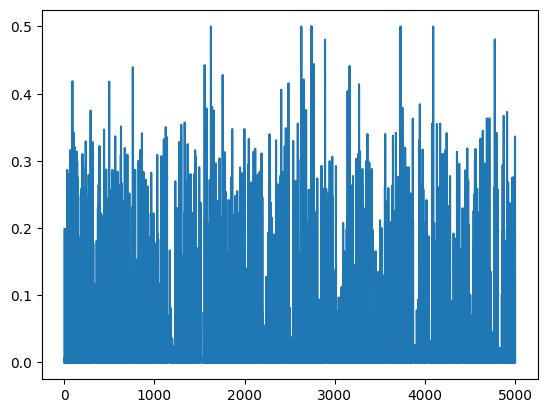

In [81]:
import matplotlib.pyplot as plt
plt.plot(source_var)

In [79]:
# source = torch.softmax(gt_x, dim=1)
# target = torch.softmax(gt_y, dim=1)

source = gt_x
target = gt_y

source_mean = torch.mean(source, dim = 0)
target_mean = torch.mean(target, dim = 0)

eps = 1e-10
max_var = 0.5
source_var = torch.var(source, dim = 0)
target_var = torch.var(target, dim = 0)

source_var = torch.clamp(source_var, min=eps, max=max_var)
target_var = torch.clamp(target_var, min=eps, max=max_var)

kld = torch.log(target_var / source_var) + ((source_var + (source_mean - target_mean) ** 2) / (2 * target_var)) - 0.5

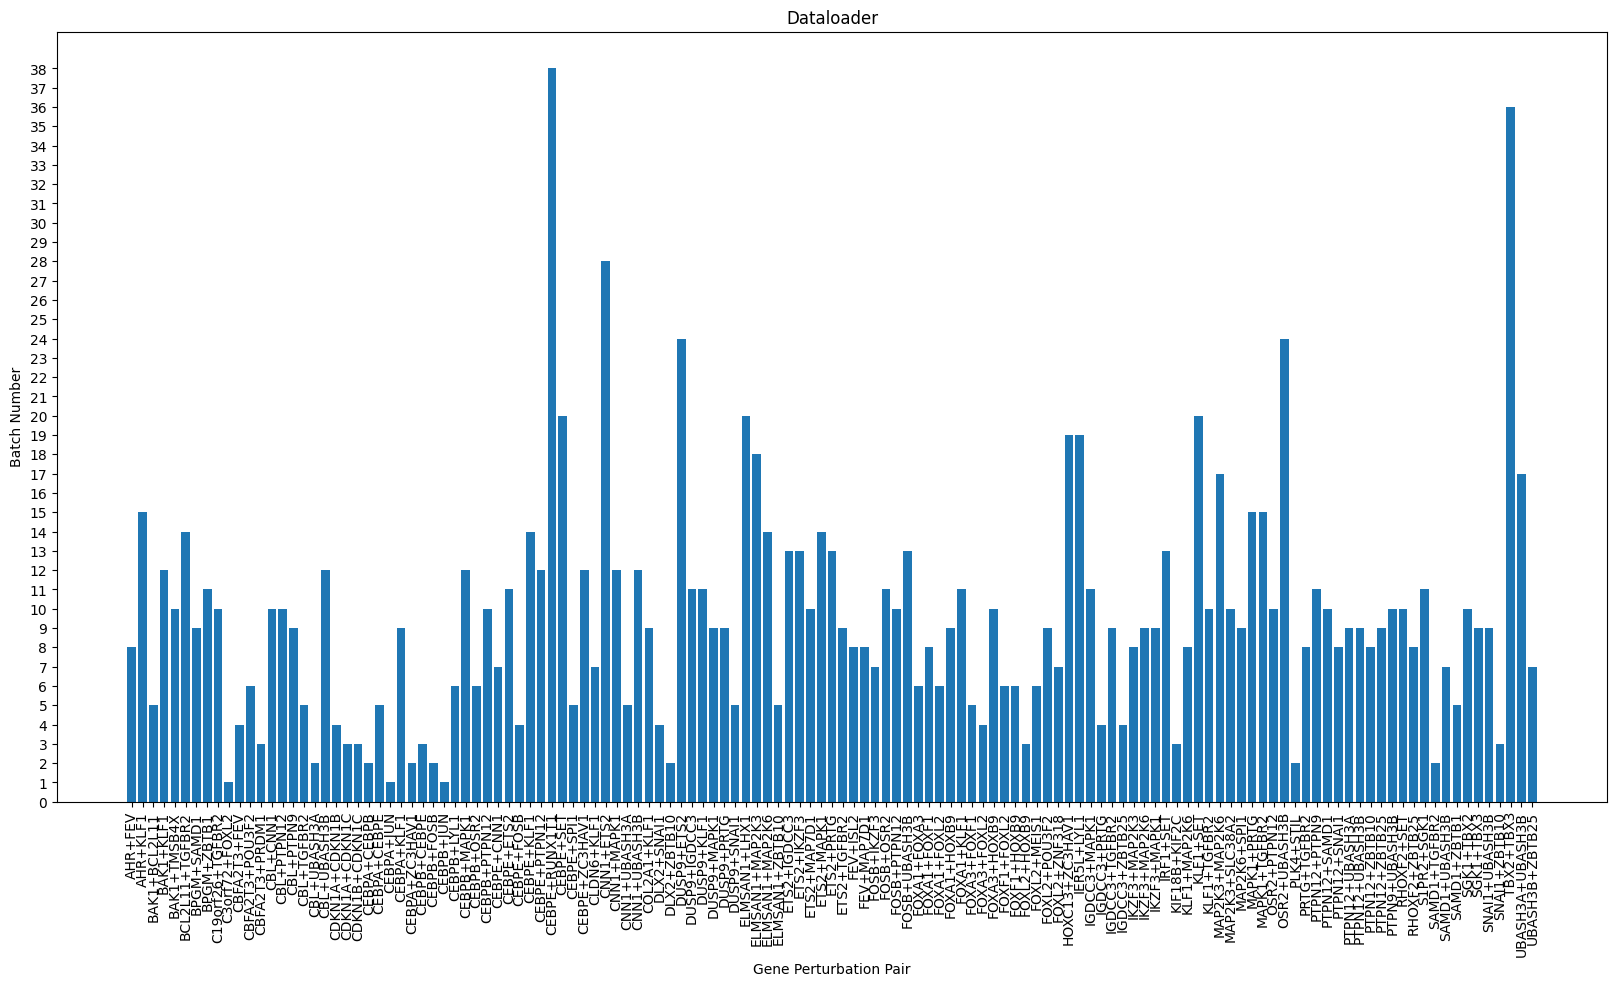

In [29]:
results = []
for i, unique_pairs in enumerate(all_pairs):
    gene_pair = "+".join([ptb_genes[unique_pairs[0]], ptb_genes[unique_pairs[1]]])
    indices = np.where(pair_indices == i)[0]
    num_batches = len(indices)
    results.append([gene_pair, num_batches])

df = pd.DataFrame(results, columns=["Gene Pair", "Num Batches"])

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.bar(df["Gene Pair"], df["Num Batches"])
plt.xticks(rotation=90)
plt.yticks(range(0, int(df["Num Batches"].max()) + 1, 1))
plt.xlabel("Gene Perturbation Pair")
plt.ylabel("Batch Number")
plt.title("Dataloader")
plt.show()

In [ ]:
pred_x_list, gt_x_list = [], []
gt_y_list, pred_y_list = [], []
c_y_list, mu_list, var_list = [], [], []
MSE_l, KLD_l, L1_l, MMD_l = [], [], [], []
cidx_list = []

mmd_loss_func = MMD_loss(fix_sigma=MMD_sigma, kernel_num=kernel_num)
loss_f = LossFunction(MMD_sigma=MMD_sigma, kernel_num=kernel_num, matched_IO=matched_IO)

for i, X in enumerate(tqdm(dataloader, desc="evaluating loader")):
    x, y, c = X[0].to(device), X[1], X[2].to(device)
    
    if numint == 2:
        idx = torch.nonzero(torch.sum(c, axis=0), as_tuple=True)[0]
        c1 = torch.zeros_like(c).to(device)
        c1[:, idx[0]] = 1
        c2 = torch.zeros_like(c).to(device)
        c2[:, idx[1]] = 1
        idx_pair = idx.cpu()
        cidx_list.append(idx_pair.numpy())
    else:
        c1 = c2 = c
    
    with torch.no_grad():
        y_hat, x_recon, z_mu, z_var, G, _ = model(
            x, c1, c2, num_interv=numint, temp=temp
            )
        
    gt_x_list.append(x.cpu())
    pred_x_list.append(x_recon.cpu())

    gt_y_list.append(y)
    pred_y_list.append(y_hat.cpu())

    c_y_list.append(c.cpu())
    mu_list.append(z_mu.cpu())
    var_list.append(z_var.cpu())

    if not i % batch_size:
        # Stack tensors
        gt_x = torch.vstack(gt_x_list)
        pred_x = torch.vstack(pred_x_list)
        gt_y = torch.vstack(gt_y_list)
        pred_y = torch.vstack(pred_y_list)
        c_y = torch.vstack(c_y_list)
        mu = torch.vstack(mu_list)
        var = torch.vstack(var_list)
        G = model.G.cpu()

        # Compute metrics
        _, MSE, KLD, L1 = loss_f.compute_loss(
            pred_y,
            gt_y,
            pred_x,
            gt_x,
            mu,
            var,
            G
        )

        # Compute MMD
        MMD = mmd_loss_func(pred_y, gt_y)

        MSE_l.append(MSE.item())
        KLD_l.append(KLD.item())
        L1_l.append(L1.item())
        MMD_l.append(MMD.item())

        # Reset lists
        pred_x_list, gt_x_list = [], []
        gt_y_list, pred_y_list = [], []
        c_y_list, mu_list, var_list = [], [], []
    if i>200:
        break

125


In [ ]:
sena_metric = pd.read_csv("./results/sena_norman_1_double_metrics.csv")
sena_metric

,double,mmd_true_vs_ctrl,mmd_true_vs_pred,mse_true_vs_ctrl,mse_true_vs_pred,kld_true_vs_ctrl,kld_true_vs_pred
0,AHR+FEV,0.101555,1.427069,0.075449,0.184683,0.003209,0.197176
1,AHR+KLF1,0.163904,0.974736,0.083472,0.168017,0.005238,0.126148
2,BAK1+BCL2L11,0.155179,0.709171,0.076095,0.138176,0.004691,0.059115
3,BAK1+KLF1,0.272017,0.730316,0.081424,0.140850,0.012928,0.062925
4,BAK1+TMSB4X,0.094348,0.730903,0.079186,0.147247,0.002892,0.071244
...,...,...,...,...,...,...,...
126,SNAI1+UBASH3B,0.124801,0.988197,0.081481,0.165803,0.004129,0.123858
127,SNAI1+ZBTB10,0.227714,1.793176,0.073301,0.198469,0.009220,0.269565
128,TBX2+TBX3,0.122947,1.054041,0.078340,0.167026,0.003947,0.133229
129,UBASH3A+UBASH3B,0.170676,0.731447,0.086566,0.156165,0.007307,0.080214
